In [56]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
from torchvision.utils import save_image

# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [57]:
path = 'C://Users/Mrudula Bapat/OneDrive/Desktop/CSULB_Course/03 - Fall 23/PR/02 - Assignments/Assignment05/lfw/lfw'

In [58]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)

This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [25]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    print ("MPS device not found.")

MPS device not found.


In [45]:
if not os.path.exists('./generated'):
    os.mkdir('./generated')


def to_img(x):
    x = x.view(x.size(0), 1, 250, 250)
    return x

torch.Size([250, 250, 3])


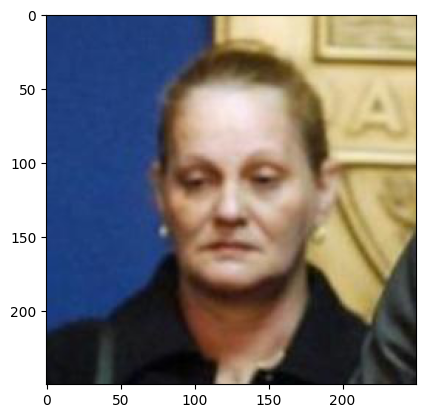

In [18]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function. 

| Autoencoder|Variational AutoEncoder |
| :--- | :--- | 
| Neural netweorks are used to convert high-dimensional input to a lower dimensional form. | Variational autoencoders also convert high-dimensional input to lower dimensional form but they also add a probabilistic element by modeling the latent space as a probability distribution. | 
| AE cannot generate new data samples. | VAE can generate new data samples by sampling from the latent space. |  
| Architecture: Consists of encoder and decoder. Encoder outputs a single value mapping to the latent space. | Architecture: Consists of encoder and decoder but the encoder maps to probability distribution | 
| Applications: Image Denoising, Feature learning, image compression. | Applications:  Generate new images, synthetic data creation, text generation. |
| Loss function: Reconstruction loss (eg. MSE between input and output) | Loss function: Reconstrucion loss + regularization  term (KL divergence)| 

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [29]:
class VAE(nn.Module):
    def __init__(self, input_dim=(3, 250, 250), hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.device = device
        self.encoder = self._build_encoder()
        self.decoder = self._build_decoder()
        
     
    def _build_encoder(self):
            return nn.Sequential(
            nn.Conv2d(in_channels=self.input_dim[0], out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * (self.input_dim[1] // 8) * (self.input_dim[2] // 8), self.hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(self.hidden_dim, self.latent_dim * 2)  # Two times latent_dim for mean and variance
        )


    def _build_decoder(self):
            return nn.Sequential(
            nn.Linear(self.latent_dim, self.hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(self.hidden_dim, 128 * (self.input_dim[1] // 8) * (self.input_dim[2] // 8)),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (128, self.input_dim[1] // 8, self.input_dim[2] // 8)),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=32, out_channels=self.input_dim[0], kernel_size=4, stride=2),
            nn.Sigmoid() 
        )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = torch.chunk(x, 2, dim=1)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(self.device)
        z = mean + var * epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar


## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly. 

In [28]:
#Create an instance of the class
model = VAE(input_dim=(3, 250, 250), hidden_dim=400, latent_dim=200, device=device)

In [83]:
for data in dataloader:
        img, y = data
        img = img.to(device)
        optimizer.zero_grad()

        mean, logvar = model.encode(img)
        print("mean shape:", mean.shape)
        print("logvar shape:", logvar.shape)
        
        output, mean, logvar = model(img)
        print("output shape:", output.shape)
        break


mean shape: torch.Size([32, 200])
logvar shape: torch.Size([32, 200])
output shape: torch.Size([32, 3, 250, 250])


## Variational Autoencoders 
- Variational autoencoders converts the input to variational representation meaning that instead of encoding the input to a single point we encode it into a latent space. 
- This variational representation is a probabilistic distribution in space. 
- Next a point in latent space is sampled from the distribution and then this sample point is decoded. 
- The reconstruction error is then computed and fed to backward propogation. 

In the above code, the input is fed in the forward pass. And it is encoded into latent space represented by the mean and standard deviation. The size of the latent space is 200. Therefore the shape of mean and logvar is (32,200) where 32 is the batch size and 200 is the latent dimensions.

The mean and logvar is then used to calculate z. The z needs to be calculated using the reparameterization trick. The reparameterization is needed so as to make the z differentiable and we can then use it for backpropogation. Reparameterization introduces Epsilon which is a random variable and helps to make the equation differentiable.

From the code above, we can also see that the shape of the output is (32,3,250,250) where 32 is the batch size, 3 is the number of channels and 250*250 is the input image dimensions. The output of the decoder should be the same size as input only then would we be able to calculate the reconstruction loss.

##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [34]:
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [35]:
#Print the total number of parameters in the model
total_parameters = sum(m.numel() for m in model.parameters())
print("Total Parameters: ", total_parameters)

Total Parameters:  99101683


### Loss function
- The loss function used consists of two parts - reconstruction loss and KL divergence loss.
- MSE : The Mean squared error is used to compute the reconstruction loss. It is calculated between input and output image. It is a differentiable loss function and can be used to update model parameters in gradient descent.
- KL loss : It is used for regularization meaning that the output data which is to be generated doesnot drastically change from its input. KL divergence is calculated using mean and logvar.
- The total loss is the sum of MSE and KL loss.

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [61]:
epochs = 50    # Number of epochs

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0.0

    for data in dataloader:
        img, y = data
        img = img.to(device)
        optimizer.zero_grad()

        # Forward pass
        output, mean, logvar = model(img)

        # Calculate MSE loss
        mse_loss = F.mse_loss(output, img)

        # Calculate KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

        # Total loss
        loss = mse_loss + kl_loss

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print loss after each epoch
    print(f'Epoch {epoch}/{epochs}, Loss: {total_loss / len(dataloader)}')

    # Save generated images after every 10 epochs
    if epoch % 10 == 1:
        with torch.no_grad():
            pic = to_img(output[0].cpu().data)
            save_image(pic, './generated/image_{}.png'.format(epoch))

Epoch 1/50, Loss: 203.05803909795037
Epoch 2/50, Loss: 2.3269498689935126
Epoch 3/50, Loss: 0.2929456787633485
Epoch 4/50, Loss: 0.14468408080524411
Epoch 5/50, Loss: 0.1302346728485206
Epoch 6/50, Loss: 0.11252146509700808
Epoch 7/50, Loss: 0.11386815227311232
Epoch 8/50, Loss: 0.09946231389867849
Epoch 9/50, Loss: 0.08794920737373418
Epoch 10/50, Loss: 0.08644712279582846
Epoch 11/50, Loss: 0.08237455065908103
Epoch 12/50, Loss: 0.07770639182678585
Epoch 13/50, Loss: 0.07610243147817151
Epoch 14/50, Loss: 0.07404778923453956
Epoch 15/50, Loss: 0.0740657909933863
Epoch 16/50, Loss: 0.07297157920126257
Epoch 17/50, Loss: 0.07606490739974482
Epoch 18/50, Loss: 0.07735474279214596
Epoch 19/50, Loss: 0.0762568193263021
Epoch 20/50, Loss: 0.07056665459069712
Epoch 21/50, Loss: 0.0657558389778795
Epoch 22/50, Loss: 0.06880410388112068
Epoch 23/50, Loss: 0.06944882882566288
Epoch 24/50, Loss: 0.06418179412340295
Epoch 25/50, Loss: 0.06471063620571432
Epoch 26/50, Loss: 0.06233288540408529
Ep

The loss value during training was decreasing at the beginning but then it was almost constant after a few epochs. i tried to improve this by changing the learning rate and also adding weight decay to the optimizer.

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

In [84]:
# Take a random batch from the dataset
random_batch = next(iter(dataloader))
random_image = random_batch[0].to(device)

In [62]:
# Generate new samples
with torch.no_grad():
    generated_output = model(random_image[0].unsqueeze(0))

In [63]:
# Convert tensors to images
from torchvision.transforms.functional import to_pil_image
original_image = to_pil_image(random_image[0].cpu().squeeze(0))
generated_image = to_pil_image(generated_output[0].cpu().squeeze(0))

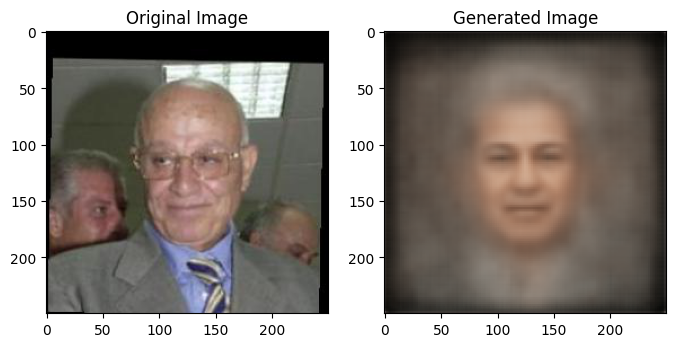

In [64]:
# Plot the images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.asarray(original_image))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(np.asarray(generated_image))
plt.title('Generated Image')

plt.show()